# DAML 10 - Online Learning

Michal Grochmal <michal.grochmal@city.ac.uk>

There are different models that support online learning but the technique to change
the model parameters during the learning is (almost) always some variant on top of
Gradient Descent (GD).
The GD is a technique which attempts to find
a minimal model error by walking through the function of model parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
plt.style.use('seaborn-talk')

## Gradient Descent

Imagine a model with two parameters (e.g. a linear regression in 2 dimensions),
for each combination of parameters we have some model error (misclassification
or distance to regression line).
The shape of this function is determined by the data to which we are fitting the model.

In offline/single batch learning we fit a model by repeating techniques that find an almost
optimal value for the parameters based on a training set.
We use cross-validation and a test set to achieve some degree of generalization.
If we try to fit this same model to a different set of data we would repeat the entire
technique and end at a reasonable solution for the new dataset.

With online learning we try to optimize the model parameters in a slightly different way.
We initialize the parameters at random and calculate the gradient over this model error
function.
The gradient is:

$$
\nabla E = \frac{\partial E}{\partial p_1}\hat{\imath} + \frac{\partial E}{\partial p_2}\hat{\jmath} + \ldots
$$

i.e. it is the partial derivative against each function parameter, in two dimensions
it is against two parameters only ($\hat{\imath}$ and $\hat{\jmath}$ are *versors*).

The gradient tells us how a function varies around the current model parameters,
and therefore it tells us in which direction lie a better (lower model error) parameters.
Yet, it does not tell us *how far away these parameter lie*.
The *learning rate*, in online learning, is the distance that we will move in the direction
of lower model error.
And after we move to those parameters we will look at the gradient
again and repeat the procedure, until convergence (or maximum iterations) is reached.

By default `sklearn` uses a learning rate (`eta0`) that is reduced at each iteration,
this allows for a technique called *Stochastic Gradient Descent* (SDG).
In SDG only some of the samples are used at each time to determine the gradient.
The decreasing learning rate allows for convergence despite the fact that not all samples
are used to calculate the gradient.
The default learning rate starts at $1/\alpha$,
where $\alpha$ is the constant multiplying the regularization term.

Let's try to visualize this on a surface:

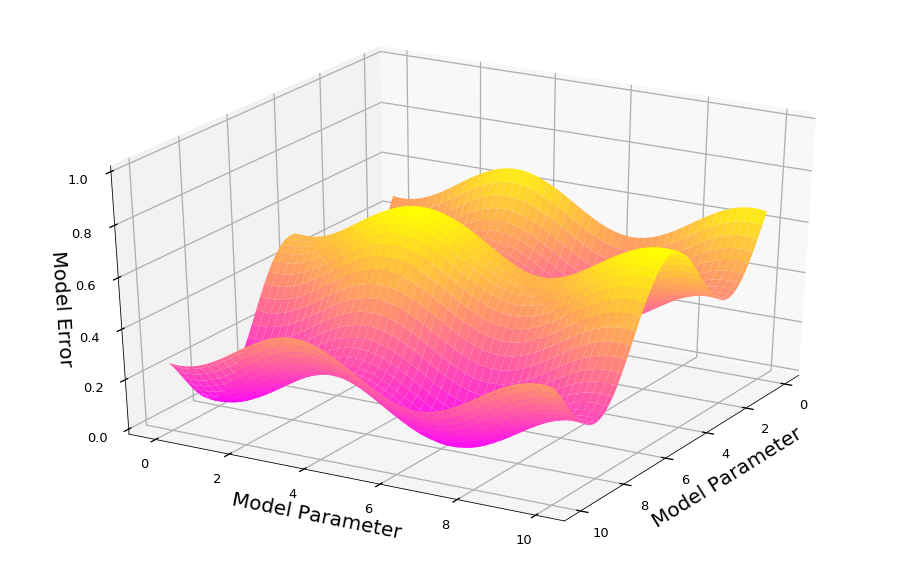

In [2]:
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
xx, yy = np.meshgrid(x, y)
z = 3*np.sin(xx) - 1 + np.sin(xx + 6) + np.cos(yy) + np.cos(yy - 0.5) + 0.6*x
z = 1 - z/20 - 0.5
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, cmap='spring')
ax.set_zlim(0, 1)
ax.set_zlabel('Model Error', fontsize=20, labelpad=10)
ax.set_xlabel('Model Parameter', fontsize=20, labelpad=15)
ax.set_ylabel('Model Parameter', fontsize=20, labelpad=15)
ax.view_init(elev=30., azim=30)

In a real problem the surface will be a high dimensional hyperplane,
since most machine learning models work in very high dimensions.
Yet, the same technique works on any number of dimensions.

The function we try to optimize is called a *cost function*,
and in several cases a cost function may be different from the
actual function we are fitting the model with.
We do not really care about all components of the gradient vector.
Each parameter in the model is a dimension of the cost function,
and the component of the gradient vector in that same dimension is an indicator of how
the error changes if we change this specific parameter/weight.
In other words the ratio of change (derivative) between error and parameter
tells us in which direction a specific parameter should be updated to reach a smaller error.
It is often written that instead of the gradient, what is used are
*directed derivatives* in the direction of every parameter/weight.

$$
\nabla E \times \vec{u} = \| \nabla E \|_2 \| u \|_2 \cos \theta
$$

For example the `Ridge` regression added an extra term to the function
we tried to optimize, and that extra term allowed us for a better fit.
The gradient descent optimizes the cost function but the model itself
predicts values based on the actual fitted function (from the model
parameters only).
In other words, we have the function (e.g. classification) we are trying to optimize,
and to find that we build and optimize a cost function,
which is a completely different function.

In `sklearn` we have `SDGClassifier` which will perform the technique
above to achieve online learning on top of linear SVMs, logistic regression, or a perceptron.
The `SDGRegressor` performs a linear regression as online learning.
Note that this means that we can only find solutions to problems
that can be approximated linearly.
For non-linear online learning we need neural networks (which we will see soon).

## Ozone Dataset

For a change let's take on a dataset that is not present inside `sklearn`.
The ozone dataset are meteorological instrument sensor measures on several days
(1998 to 2004) and whether these days had high ozone concentration.
This allows for the prediction of high ozone days.

But first we need to write a function to actually retrieve the dataset,
we will duplicate the `sklearn` convention for dataset loading and construct
our `load_ozone` function.

In [3]:
import os
import sys
import requests
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.utils import Bunch


def load_ozone():
    ozone_dir = 'uci_ozone'
    data_dir = datasets.get_data_home()
    data_path = os.path.join(data_dir, ozone_dir, 'onehr.data')
    descr_path = os.path.join(data_dir, ozone_dir, 'onehr.names')
    ozone_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/onehr.data'
    ozone_descr = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/onehr.names'
    os.makedirs(os.path.join(data_dir, ozone_dir), exist_ok=True)
    columns = [
        'WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9',
        'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19',
        'WSR20', 'WSR21', 'WSR22', 'WSR23', 'WSR_PK', 'WSR_AV',
        'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
        'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
        'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85',
        'RH85', 'U85', 'V85', 'HT85', 'T70', 'RH70', 'U70', 'V70',
        'HT70', 'T50', 'RH50', 'U50', 'V50', 'HT50', 'KI', 'TT',
        'SLP', 'SLP_', 'Precp', 'Ozone']
    try:
        with open(descr_path, 'r') as f:
            descr = f.read()
    except IOError:
        print('Downloading file from', ozone_descr, file=sys.stderr)
        r = requests.get(ozone_descr)
        with open(descr_path, 'w') as f:
            f.write(r.text)
        descr = r.text
        r.close()
    try:
        data = pd.read_csv(data_path, delimiter=',',
                           na_values=['?'], names=columns, parse_dates=True)
        data.fillna(data.mean(), inplace=True)
    except IOError:
        print('Downloading file from', ozone_data, file=sys.stderr)
        r = requests.get(ozone_data)
        with open(data_path, 'w') as f:
            f.write(r.text)
        r.close()
        data = np.loadtxt(data_path, delimiter=',')
    return Bunch(DESCR=descr,
                 data=data.values[:, :72],
                 feature_names=columns[:72],
                 target=data.values[:, 72],
                 target_names=['normal day', 'ozone day'])


ozone = load_ozone()
print(ozone.DESCR)

1. Title: Ozone Level Detection


2. Source:

Kun Zhang
zhang.kun05 '@' gmail.com
Department of Computer Science, 
Xavier University of Lousiana

Wei Fan
wei.fan '@' gmail.com
IBM T.J.Watson Research

XiaoJing Yuan
xyuan '@' uh.edu
Engineering Technology Department, 
College of Technology, University of Houston 


3. Past Usage:

Forecasting skewed biased stochastic ozone days: analyses, solutions and beyond, Knowledge and Information Systems, Vol. 14, No. 3, 2008.
Discusses details about the dataset, its use as well as various experiments (both cross-validation and streaming) using many state-of-the-art methods.

A shorter version of the paper (does not contain some detailed experiments as the journal paper above) is in:
Forecasting Skewed Biased Stochastic Ozone Days: Analyses and Solutions. ICDM 2006: 753-764 


4. Relevant Information:

The following are specifications for several most important attributes 
that are highly valued by Texas Commission on Environmental Quality (TCEQ).

We have a real dataset, we should treat it as a real problem.
We take out a test set which we will not touch.

In [4]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    ozone.data, ozone.target, test_size=0.2, random_state=42)

And train on the training set with cross-validation.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

model = make_pipeline(
    StandardScaler(),
    PCA(n_components=20),
    SGDClassifier(loss='log', penalty='l1',
                  max_iter=500, alpha=0.001, tol=0.01, class_weight={0: 1, 1: 25}))
param_grid = {
    'sgdclassifier__alpha': [0.001, 0.01, 0.1],
    'sgdclassifier__tol': [0.001, 0.01, 0.1],
}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(xtrain, ytrain)
grid.best_score_

/home/grochmal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.89151873767258383

Some of the models during grid search may not converge.
That's completely fine, we did root them out through the cross-validation.
The best model is likely to be one that did converge.

In [6]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('sgdclassifier', SGDClassifier(alpha=0.001, average=False, class_weight={0: 1, 1: 25},...='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.01, verbose=0, warm_start=False))])

Finally evaluate on the test set.

In [7]:
from sklearn.metrics import classification_report

yfit = grid.best_estimator_.predict(xtest)
print(classification_report(ytest, yfit, target_names=ozone.target_names))

             precision    recall  f1-score   support

 normal day       0.99      0.90      0.94       499
  ozone day       0.07      0.44      0.12         9

avg / total       0.97      0.89      0.93       508



Hey!  That wasn't online learning.

Right, it was not.
The ozone dataset is small enough to fit in memory
and we are not expecting to receive any new data,
yet we can make up that by slitting into two sets of data and train SDG in an online fashion.
We will *misuse* the `train_test_split` function for this.

In [8]:
ozone1, ozone2, yozone1, yozone2 = train_test_split(
    ozone.data, ozone.target, test_size=0.5, random_state=42)

In `sklearn` there are two ways of using online learning.
One is to use a method called `partial_fit`, instead of `fit`,
which will update parameters instead of fitting completely new ones.
Another way to enable online learning is to pass `warm_start=True`,
this forces `fit` to always work like `partial_fit`.

Both methods only work on models that inherently support online learning.

In [9]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(
    ozone1, yozone1, test_size=0.2, random_state=0)
model = make_pipeline(
    StandardScaler(),
    PCA(n_components=10),
    SGDClassifier(loss='hinge', penalty='l1', max_iter=200, alpha=0.001,
                  tol=0.001, warm_start=True, class_weight={0: 1, 1: 25}))
model.fit(xtrain1, ytrain1)
yfit = model.predict(xtest1)
print(classification_report(ytest1, yfit, target_names=ozone.target_names))

             precision    recall  f1-score   support

 normal day       0.98      0.91      0.95       248
  ozone day       0.08      0.33      0.13         6

avg / total       0.96      0.90      0.93       254



We know about half of the data and we can, more-or-less, classify that.
But if we try to classify the data we do not know about we may run into trouble.

In [10]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(
    ozone2, yozone2, test_size=0.2, random_state=0)
yfit = model.predict(xtest2)
print(classification_report(ytest2, yfit, target_names=ozone.target_names))

             precision    recall  f1-score   support

 normal day       0.98      0.89      0.93       246
  ozone day       0.12      0.50      0.20         8

avg / total       0.95      0.87      0.91       254



We can train with some data from the second dataset and see if things improve.

In [11]:
model.fit(xtrain2, ytrain2)
yfit = model.predict(xtest2)
print(classification_report(ytest2, yfit, target_names=ozone.target_names))

             precision    recall  f1-score   support

 normal day       0.98      0.92      0.95       246
  ozone day       0.14      0.38      0.20         8

avg / total       0.95      0.91      0.93       254



## Extra: Non-GD Optimisation

We saw SGD and said that it is the most often used optimization technique.
But what are the others?
One technique is **simulated annealing** which works by slow cooling.
In summary: simulated annealing tries random neighbors at each iteration and keeps
track of of the point with the lowest value of the cost function.
The search space for a new neighbor (i.e. the maximum distance form the lowest point
found until now) reduces at each iteration.
This is similar to SGD with a decreasing learning rate.

But there are more techniques.
Notably **swarm intelligence** provides us with several optimization algorithms:

- particle swarm
- bat swarm
- cuckoo search

And **genetic algorithms** also work reasonably in an online learning scenario.

## References

[UCI - Ozone Level Detection Dataset][1]

[1]: https://archive.ics.uci.edu/ml/datasets/ozone+level+detection "UCI - Ozone"